In [1]:
import warnings
warnings.filterwarnings('ignore')

# Create a Planar Design

In [2]:
from qiskit_metal import designs, MetalGUI

design = designs.DesignPlanar()
design.overwrite_enabled = True

# Define Chip size

In [3]:
design.chips.main.size_x = '12mm'
design.chips.main.size_y = '10mm'

# Open Metal GUI

In [4]:
gui = MetalGUI(design)

# Place the Transmons

In [5]:
from qiskit_metal.qlibrary.qubits.transmon_pocket_cl import TransmonPocketCL

design.delete_all_components()

# Some local variables to modularize the deesign
design_span_x = 5
design_span_y = 3

half_chip_width = design_span_x / 2
half_chip_height = design_span_y / 2

connection_pads_options = dict(
    a = dict(loc_W=1, loc_H=-1),
    b = dict(loc_W=1, loc_H=1),
    c = dict(loc_W=-1, loc_H=-1)
)

transmons = []

transmons.append(TransmonPocketCL(design, 'Q1',
                      options=dict(pos_x=f'-{half_chip_width}mm',
                                   pos_y=f'{-half_chip_height}mm',
                                   connection_pads=dict(**connection_pads_options))))

transmons.append(TransmonPocketCL(design, 'Q2',
                      options=dict(pos_x=f'0mm',
                                   pos_y=f'{half_chip_height}mm',
                                   orientation=-90,
                                   connection_pads=dict(d=dict(loc_W=-1, loc_H=1), **connection_pads_options))))

transmons.append(TransmonPocketCL(design, 'Q3',
                      options=dict(pos_x=f'0mm',
                                   pos_y=f'{-half_chip_height}mm',
                                   orientation=90,
                                   connection_pads=dict(d=dict(loc_W=-1, loc_H=1), **connection_pads_options))))

transmons.append(TransmonPocketCL(design, 'Q4',
                      options=dict(pos_x=f'{half_chip_width}mm',
                                   pos_y=f'{half_chip_height}mm',
                                   orientation=180,
                                   connection_pads=dict(**connection_pads_options))))

gui.rebuild()
gui.autoscale()

# Connect using Meeandeered Routes (Co-planar Waveguides)

In [8]:
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal import Dict

# Options for the meaders
fillet='99.99um'
options = Dict(
    meander=Dict(
        lead_start='0.1mm',
        lead_end='0.1mm',
        asymmetry='0 um')
)

# Helper function to connect thee meandered routes
def connect(component_name: str, component1: str, pin1: str, component2: str, pin2: str,
            length: str,
            asymmetry='0 um', start_strght='0 um', end_strght='0 um', flip=False):
    """Connect two pins with a CPW."""
    myoptions = Dict(
        pin_inputs=Dict(
            start_pin=Dict(
                component=component1,
                pin=pin1),
            end_pin=Dict(
                component=component2,
                pin=pin2)),
        lead=Dict(
            start_straight=start_strght,
            end_straight=end_strght
        ),
        total_length=length,
    fillet = '99.9um')
    myoptions.update(options)
    myoptions.meander.asymmetry = asymmetry
    myoptions.meander.lead_direction_inverted = 'true' if flip else 'false'
    return RouteMeander(design, component_name, myoptions)


# Define asymmetry (itrative process)
asym_h = 100
asym_v = 100
cpw = []

# Connect CPW coulers between qubits (with some arbitrary length initially)
cpw.append(connect('cpw1', 'Q1', 'b', 'Q2', 'a', '8 mm', f'+{asym_h}um', '0.1mm', '0.1mm'))
cpw.append(connect('cpw2', 'Q3', 'b', 'Q2', 'b', '8 mm', f'-{asym_v}um', '0.6mm', '0.4mm'))
cpw.append(connect('cpw3', 'Q4', 'b', 'Q3', 'a', '8 mm', f'+{asym_h}um', '0.1mm', '0.1mm'))
cpw.append(connect('cpw4', 'Q3', 'd', 'Q1', 'a', '8 mm', f'-{asym_h}um', '0.1mm', '0.1mm'))
cpw.append(connect('cpw5', 'Q2', 'd', 'Q4', 'a', '8 mm', f'-{asym_h}um', '0.1mm', '0.1mm'))


gui.rebuild()
gui.autoscale()

In [9]:
from qiskit_metal.analyses.em.cpw_calculations import guided_wavelength

def find_resonator_length(frequency, line_width, line_gap, N): 
    #frequency in GHz
    #line_width/line_gap in um
    #N -> 2 for lambda/2, 4 for lambda/4
    
    [lambdaG, etfSqrt, q] = guided_wavelength(frequency*10**9, line_width*10**-6,
                                              line_gap*10**-6, 750*10**-6, 200*10**-9)
    return str(lambdaG/N*10**3)+" mm"

In [10]:
find_resonator_length(6.5, 15, 1, 2)

'9.637925419647706 mm'

# Place Lauchpads for Readouts and ChargeLine

In [12]:
from qiskit_metal.qlibrary.terminations.launchpad_wb_coupled import LaunchpadWirebondCoupled

readouts_lwc = []
cl_lwc = []

offset_x = 0
offset_y = 1


#Readouts
readouts_lwc.append(LaunchpadWirebondCoupled(design, 'R1',
                                         options = dict(
                                         pos_x = '-5mm',
                                         pos_y = f'-{half_chip_height+offset_y}mm',
                                         lead_length = '30um')))

readouts_lwc.append(LaunchpadWirebondCoupled(design, 'R2',
                                         options = dict(
                                         pos_x = '-1mm',
                                         pos_y = '4mm',
                                         orientation = -90,
                                         lead_length = '30um')))

readouts_lwc.append(LaunchpadWirebondCoupled(design, 'R3',
                                         options = dict(
                                         pos_x = '1mm',
                                         pos_y = '-4mm',
                                         orientation = 90,
                                         lead_length = '30um')))

readouts_lwc.append(LaunchpadWirebondCoupled(design, 'R4',
                                         options = dict(
                                         pos_x = '5mm',
                                         pos_y = f'{half_chip_height+offset_y}mm',
                                         orientation = 180,
                                         lead_length = '30um')))

#Controls
cl_lwc.append(LaunchpadWirebondCoupled(design, 'CL1',
                                         options = dict(
                                         pos_x = '-5mm',
                                         pos_y = '2mm',
                                         lead_length = '30um')))

cl_lwc.append(LaunchpadWirebondCoupled(design, 'CL2',
                                         options = dict(
                                         pos_x = '4mm',
                                         pos_y = '4mm',
                                         orientation = -90,
                                         lead_length = '30um')))

cl_lwc.append(LaunchpadWirebondCoupled(design, 'CL3',
                                         options = dict(
                                         pos_x = '-4mm',
                                         pos_y = '-4mm',
                                         orientation = 90,
                                         lead_length = '30um')))

cl_lwc.append(LaunchpadWirebondCoupled(design, 'CL4',
                                         options = dict(
                                         pos_x = '5mm',
                                         pos_y = '-2mm',
                                         orientation = 180,
                                         lead_length = '30um')))

gui.rebuild()
gui.autoscale()

# Connect Readouts

In [13]:
readout_lines = []

asym_14 = 700
asym_23 = 700
options = Dict(
    lead=Dict(
        start_straight='430um',
        end_straight='0um'),
    fillet='99.99um')

readout_lines.append(connect('ol1', 'Q1', 'c', 'R1', 'tie', '8 mm', f'{asym_14}um'))
readout_lines.append(connect('ol2', 'Q2', 'c', 'R2', 'tie', '8 mm', f'{asym_23}um'))
readout_lines.append(connect('ol3', 'Q3', 'c', 'R3', 'tie', '8 mm', f'{asym_23}um'))
readout_lines.append(connect('ol4', 'Q4', 'c', 'R4', 'tie', '8 mm', f'{asym_14}um'))

gui.rebuild()
gui.autoscale()

# Connect Charge Lines

In [14]:
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors
from collections import OrderedDict
import numpy as np

control_lines = []

def connectRouteAnchor(name: str,
                       component1: str, pin1: str, component2: str, pin2: str,
                       anchor_points: OrderedDict) -> RouteAnchors:

    options_line_cl = dict(
        pin_inputs = dict(start_pin = dict(component = component1, pin = pin1),
                          end_pin = dict(component = component2, pin = pin2)),
        anchors = anchor_points,
        lead = dict(start_straight = '200um',
                    end_straight = '225um'),
        fillet = fillet
    )
    
    return RouteAnchors(design, name, options_line_cl)



anchors1c = OrderedDict()
anchors1c[0] = np.array([-4, -1.42])
anchors1c[1] = np.array([-4, 2])

control_lines.append(connectRouteAnchor('line_cl1', 'Q1', 'Charge_Line', 'CL1', 'tie', anchors1c))


anchors2c = OrderedDict()
anchors2c[0] = np.array([0.08, 3.25])
anchors2c[1] = np.array([4, 3.25])

control_lines.append(connectRouteAnchor('line_cl2', 'Q2', 'Charge_Line', 'CL2', 'tie', anchors2c))

anchors3c = OrderedDict()
anchors3c[0] = np.array([-0.08, -3.25])
anchors3c[1] = np.array([-4, -3.25])

control_lines.append(connectRouteAnchor('line_cl3', 'Q3', 'Charge_Line', 'CL3', 'tie', anchors3c))

anchors4c = OrderedDict()
anchors4c[0] = np.array([4, 1.42])
anchors4c[1] = np.array([4, -2])

control_lines.append(connectRouteAnchor('line_cl4', 'Q4', 'Charge_Line', 'CL4', 'tie', anchors4c))

gui.rebuild()
gui.autoscale()

# Target Frequencies

In [16]:
# Qubit Frequencies
# Q1 : 5
# Q2 : 5.1
# Q3 : 5.2
# Q4 : 5.3

# Readout Frequencies
# R1 : 7
# R2 : 7.1
# R3 : 7.2
# R4 : 7.3

# CPW Frequencies
# cpw1 : 7.5
# cpw2 : 7.6
# cpw3 : 7.7
# cpw4 : 7.8
# cpw5 : 7.9

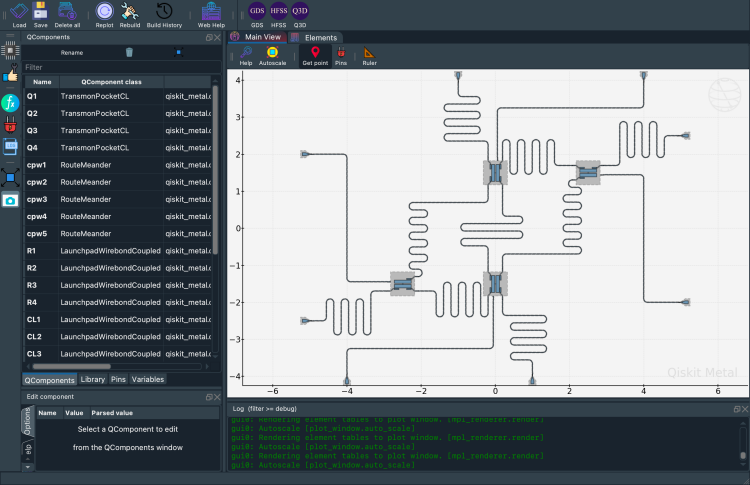

In [17]:
gui.screenshot()